In [ ]:
# SQL query setup : cust based or type based
# return after AD apply is None 
# perhaps take the prophet plot out of the AD class but you'll have to save forecast and model (maybe to the dataclass)

In [79]:
import sqlalchemy
import pandas as pd
from sqlalchemy import text
import os
from dotenv import load_dotenv
from pathlib import Path

import os

import prophet
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from prophet import Prophet
import ruptures as rpt
from ruptures.utils import pairwise
from itertools import cycle

from slack.web.client import WebClient
from slack.errors import SlackApiError



mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False


In [80]:

dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)

password = os.getenv('PASSWORD')
user = os.getenv('USER')
host = os.getenv('HOST')
database = os.getenv('DATABASE')
slack_token = os.getenv('SLACK_TOKEN')

In [88]:
engine = sqlalchemy.create_engine(f'postgresql://{user}:{password}@{host}/{database}')

client = WebClient(token=slack_token)


In [4]:
from dataclasses import dataclass
@dataclass
class AnomalyData:
    df : pd.DataFrame
    customer : str
    P : float
    outliers : list
    changepoints : list
    # extract_date
    # ad_params: dict[str, object]

In [34]:
#module function

def reindex_df(df_inp):
    start_date = df_inp.ds.iloc[0] 
    end_date = df_inp.ds.iloc[-1]
    idx = pd.date_range(start_date, end_date)

    df = df_inp.set_index('ds')#,inplace=True)
    df = df.reindex(idx)
    df['y']= df['y'].interpolate(method='linear')
    df = df.rename_axis('ds').reset_index()
    return df

In [95]:
queries = [
    '''
    SELECT a.customer as customer,
    DATE(a.startdate) as ds,
    COUNT(DISTINCT r.driverid) as y
    FROM log_riskscore r
    LEFT JOIN log_apicall a on r.apicallid=a.id
    AND a.startdate > date :startdate
    AND a.startdate <= date :extract_date
    WHERE a.route ='score_drivers'
    GROUP BY a.customer, DATE(a.startdate)
    '''
    ]


class DataGenerator(object):
    def __init__(self,queries, engine, extract_window = 90, **ad_params):
        self.queries = queries
        self.extract_window = extract_window
        self.engine = engine
        # self.ad_params = ad_params
        # self.datetime_colname = datetime_colname #(ad_param)
        # self.y_colname = y_colname # (ad_param)
        # possibly add the test and train window lengths so we can filter out dfs with len < test+train window
        # return self

    def run(self):
        
        with self.engine.connect() as con:
            for query in self.queries:
                sql = text(query)
                df = pd.read_sql_query(sql, con, params={'startdate':(pd.Timestamp('today') - pd.Timedelta(days=self.extract_window)).strftime("%Y-%m-%d"), 'extract_date':pd.Timestamp('today').strftime("%Y-%m-%d")})
                # This data contains all customers
                output = []
                customer_names = df.customer.unique()
                #create a data frame dictionary to store your data frames
                dataframe_dict = {cust : pd.DataFrame() for cust in customer_names}

                for key in dataframe_dict.keys():
                    dataframe_dict[key] = df.drop('customer', axis=1)[df.customer == key]
                    dataframe_dict[key].ds = pd.to_datetime(dataframe_dict[key].ds)
                    dataframe_dict[key].reset_index(inplace=True, drop=True)
                    ad = AnomalyData(dataframe_dict[key], customer=key, P=0, outliers= list(), changepoints=list())
                    output.append(ad)

        # the output will contaim certain customers who don't have enough data 
        # let's retain the dfs that have atleast entries over half the extract window
        # aka if we extract for 90 days, lets delete the data that are less than 45 entries 
        filtered_output = [i for i in output if len(i.df) >= 0.75*(self.extract_window)]

        # the index of all these dfs needs to be reset because the train/test indices wont work otherwise
        for o in filtered_output:
            o.df.reset_index(inplace=True, drop=True)
            o.df = reindex_df(o.df)

        return filtered_output

In [36]:
raw_data = DataGenerator(engine=engine, queries=queries).run()

In [39]:
raw_data

[AnomalyData(df=           ds      y
 0  2022-09-28  149.0
 1  2022-09-29  149.0
 2  2022-09-30  149.0
 3  2022-10-01  148.0
 4  2022-10-02  148.0
 ..        ...    ...
 58 2022-11-25  152.0
 59 2022-11-26  152.0
 60 2022-11-27  152.0
 61 2022-11-28  152.0
 62 2022-11-29  152.0
 
 [63 rows x 2 columns], customer='aim', P=0, outliers=[], changepoints=[]),
 AnomalyData(df=           ds      y
 0  2022-09-28  373.0
 1  2022-09-29  376.0
 2  2022-09-30  375.0
 3  2022-10-01  376.0
 4  2022-10-02  376.0
 ..        ...    ...
 85 2022-12-22  369.0
 86 2022-12-23  368.0
 87 2022-12-24  368.0
 88 2022-12-25  368.0
 89 2022-12-26  368.0
 
 [90 rows x 2 columns], customer='andrustransportation', P=0, outliers=[], changepoints=[]),
 AnomalyData(df=           ds       y
 0  2022-09-28  1612.0
 1  2022-09-29  1611.0
 2  2022-09-30  1609.0
 3  2022-10-01  1604.0
 4  2022-10-02  1604.0
 ..        ...     ...
 85 2022-12-22  1589.0
 86 2022-12-23  1534.0
 87 2022-12-24  1592.0
 88 2022-12-25  1592.0
 

In [98]:
class AnomalyDetector:
    def __init__(self, data, test_window=14, train_window=21, beta=0.1, 
    ruptures_changepnt_penalty=10, prophet_interval_width=0.95, 
    prophet_changepnt_prior = 0.15, weekly_seasonality= False):
        '''
        Args
        ---
        changepoint_penalty: float
        Higher the value, more conservative the segmentation, must be >0
        '''
        self.data = data
        self.test_window = test_window
        self.train_window = train_window
        self.beta = beta
        self.ruptures_changepnt_penalty = ruptures_changepnt_penalty
        self.prophet_interval_width = prophet_interval_width
        self.prophet_changepnt_prior = prophet_changepnt_prior
        self.weekly_seasonality = weekly_seasonality

    def apply(self):
        self.apply_changepnt_detection().prophet_fit().get_outliers()#.prophet_plot()
        return self



    def apply_changepnt_detection(self,changepnt_model="rbf"):
            
        '''
        Apply changepoint detection ala ruptures package and generate breakpoint indices
        Args
        ---
        changepoint_model: str
            Pelt segment model, ["l1", "l2", "rbf"] 
            https://centre-borelli.github.io/ruptures-docs/code-reference/detection/pelt-reference/

        
        Returns
        ---
        breakpoints: list
            List of breakpoint indices
        '''
        signal = self.data.df['y'].to_numpy()
        algo = rpt.Pelt(model=changepnt_model).fit(signal)
        result = algo.predict(pen=self.ruptures_changepnt_penalty)
        breakpoints = [0] + sorted(result)
        self.data.changepoints = breakpoints
        return self

    def plot_changepoints(self): 
        color_cycle = cycle(self.color_cycle)
        fig, ax = plt.subplots(1,1,figsize=(16,8))
        ax.plot(self.data.df['ds'],self.data.df['y'], '-o', markersize=2, linewidth=1)
        for (start, end), col in zip(pairwise(self.data.breakpoints), color_cycle):
            ax.axvspan(self.data.df.iloc[max(0,start-1)]['ds'], self.data.df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)
        plt.show()

    def prophet_fit(self):

        #instantiate the prophet model
        prophet_model = Prophet(interval_width=self.prophet_interval_width,
            yearly_seasonality=False,
            weekly_seasonality=self.weekly_seasonality,
            changepoint_prior_scale=self.prophet_changepnt_prior
            )
        
        #segment time frames
        # Test/Forecast window
        end_index = self.data.df.index[-1]
        test_start_index = end_index - self.test_window + 1 
        print(f'TEST start index is {test_start_index}')
        print(f'TEST END index is {end_index}') #the test end index is setup to be the last index of df
        
        # Train window, starts at the last changepoint unless the train window goes further back
        if test_start_index - self.data.changepoints[-2] < self.train_window:
            train_start_index = test_start_index - self.train_window
        else:
            train_start_index = self.data.changepoints[-2]
        print(f'TRAIN start index is {train_start_index}')

        train_end_index = test_start_index - 1
        print(f'TRAIN end index is {train_end_index}')
        baseline_ts = self.data.df['ds'][train_start_index:train_end_index]
        baseline_y = self.data.df['y'][train_start_index:train_end_index]
        print('TRAIN from {} to {}'.format(self.data.df['ds'][train_start_index], self.data.df['ds'][train_end_index]))
        print('PREDICT from {} to {}'.format(self.data.df['ds'][test_start_index], self.data.df['ds'][end_index]))

        # fit the model
        prophet_model.fit(pd.DataFrame({'ds': baseline_ts.values,
                                        'y': baseline_y.values}))#,  algorithm = 'Newton')
        
        future = prophet_model.make_future_dataframe(periods=self.test_window)
        # make prediction
        forecast = prophet_model.predict(future)
        self.forecast = forecast
        self.model = prophet_model
        return self

    def get_outliers(self):
        """
        Combine the actual values and forecast in a data frame and identify the outliers
        Args
        ----
        df : pandas DataFrame
            The daily time-series data set contains ds column for
            dates (datetime types such as datetime64[ns]) and y column for numerical values
        forecast : pandas DataFrame
            The predicted result in a dataframe which was previously generated by
            Prophet's model.predict(future)
        beta : float
            amplifying factor for setting lower and upperbounds for anomalies
        test_window : int
            Number of days for Prophet to make predictions for
        Returns
        -------
        outliers : a list of (datetime, int, int) triple
            A list of outliers, the date, the value, and penalty for each
        df_pred : pandas DataFrame
            The data set contains actual and predictions for the forecast time frame
        P : int
            Net penalty value of all the outliers detected
        """
        df_pred = self.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(self.test_window)
        df_pred.index = df_pred['ds'].dt.to_pydatetime()
        df_pred.columns = ['ds', 'preds', 'lower_y', 'upper_y']
        end_index = self.data.df.index[-1]

        test_start_index = end_index - self.test_window 
        df_pred['actual'] = self.data.df['y'][test_start_index: end_index].values

        # construct a list of outliers
        outlier_index = list()
        outliers = list()
        penalty = list()
        P = 0 # net penalty
        for i in range(df_pred.shape[0]):
            actual_value = df_pred['actual'][i]
            pred_value   = df_pred['preds'][i]
            lower_bound  = (1-self.beta)*df_pred['lower_y'][i]
            upper_bound  = (1+self.beta)*df_pred['upper_y'][i]
            if actual_value < lower_bound:
                outlier_index += [i]
                p = (pred_value - actual_value)/pred_value
                penalty.append(p)
                outliers.append((df_pred.index[i], actual_value, p))
                
            elif actual_value > upper_bound:
                outlier_index += [i]
                p = (actual_value - pred_value)/pred_value
                penalty.append(p)
                outliers.append((df_pred.index[i], actual_value, p))            

                # print out the evaluation for each outlier
                print('=====')
                print('actual value {} fall outside of the prediction interval'.format(actual_value))
                print('interval: {} to {}'.format(lower_bound, upper_bound))
                print('Date: {}'.format(str(df_pred.index[i])[:10]))

        P = sum(penalty)
        print('Net Penalty for the prediction interval of last {} days is {}'.format(self.test_window, P))
        for outlier in outliers:
            print(outlier)
        
        self.data.outliers = outliers #list
        self.data.P = P  #scalar

        return self



    # def prophet_plot(self):#df, forecast, prophet_model, changepoints_list, outliers=list()):
    #     """
    #     Plot the actual, predictions, and anomalous values
    #     Args
    #     ----
    #     df : pandas DataFrame
    #         The daily time-series data set contains ds column for
    #         dates (datetime types such as datetime64[ns]) and y column for numerical values

    #     outliers : a list of (datetime, int) tuple
    #         The outliers we want to highlight on the plot.
    #     """
    #     # generate the plot
    #     fig = self.model.plot(self.forecast)
        
    #     # retrieve the subplot in the generated Prophets matplotlib figure
    #     ax = fig.get_axes()[0]
    #     ax.set_ylim(ymin=0)
    #     #plot actual values
    #     x_pydatetime = self.data.df['ds'].dt.to_pydatetime()
    #     ax.plot(x_pydatetime,
    #         self.data.df.y,
    #         color='orange', label='Actual')

    #     # plot each outlier in red, uncomment the second line to annotate date (makes it super crowded though)
    #     for outlier in self.data.outliers:
    #         ax.scatter(outlier[0], outlier[1], s = 16, marker='x', color='red', label='Anomaly')
    #         # ax.text(outlier[0], outlier[1], str(outlier[0])[:10], color='red')


    #     # re-organize the legend
    #     patch1 = mpatches.Patch(color='red', label='Anomaly')
    #     patch2 = mpatches.Patch(color='orange', label='Actual')
    #     patch3 = mpatches.Patch(color='skyblue', label='Prediction interval')
    #     plt.legend(handles=[patch1, 
    #                         patch2, 
    #                         patch3, 
    #                         ])
        
    #     #plot the changepoints

    #     color_cycle = cycle(self.color_cycle)
    #     for (start, end), col in zip(pairwise(self.data.changepoints), color_cycle):
    #         ax.axvspan(self.data.df.iloc[max(0,start-1)]['ds'], self.data.df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)

    #     plt.show()
    #     return self
        


In [93]:
def prophet_plot(ad, color_cycle = ["#4286f4", "#f44174"], post_to_slack=True):#df, forecast, prophet_model, changepoints_list, outliers=list()):
    """
    Plot the actual, predictions, and anomalous values
    Args
    ----
    df : pandas DataFrame
        The daily time-series data set contains ds column for
        dates (datetime types such as datetime64[ns]) and y column for numerical values

    outliers : a list of (datetime, int) tuple
        The outliers we want to highlight on the plot.
    """
    # generate the plot
    fig = ad.model.plot(ad.forecast)
    
    # retrieve the subplot in the generated Prophets matplotlib figure
    ax = fig.get_axes()[0]
    ax.set_ylim(ymin=0)
    #plot actual values
    x_pydatetime = ad.data.df['ds'].dt.to_pydatetime()
    ax.plot(x_pydatetime,
        ad.data.df.y,
        color='orange', label='Actual')

    # plot each outlier in red, uncomment the second line to annotate date (makes it super crowded though)
    for outlier in ad.data.outliers:
        ax.scatter(outlier[0], outlier[1], s = 16, marker='x', color='red', label='Anomaly')
        # ax.text(outlier[0], outlier[1], str(outlier[0])[:10], color='red')


    # re-organize the legend
    patch1 = mpatches.Patch(color='red', label='Anomaly')
    patch2 = mpatches.Patch(color='orange', label='Actual')
    patch3 = mpatches.Patch(color='skyblue', label='Prediction interval')
    plt.legend(handles=[patch1, 
                        patch2, 
                        patch3, 
                        ])
    
    #plot the changepoints

    color_cycle = cycle(color_cycle)
    for (start, end), col in zip(pairwise(ad.data.changepoints), color_cycle):
        ax.axvspan(ad.data.df.iloc[max(0,start-1)]['ds'], ad.data.df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)

    if post_to_slack:

        plt.savefig('AD.jpg')
        try:
            response = client.files_upload(
                file='AD.jpg',
                title=f'{ad.data.customer} Penalty = {ad.data.P}',
                channels='anomaly-detection'
            )
        except SlackApiError as e:
            # You will get a SlackApiError if "ok" is False
            assert e.response["ok"] is False
            assert e.response["error"]  # str like 'invalid_auth', 'channel_not_found'
            print(f"Got an error: {e.response['error']}")
    plt.show()
    



In [ ]:
# scores.sort(lambda ad: ad.P)
raw_data = raw_data = DataGenerator(engine=engine, queries=queries, extract_window=35).run()
ads = [AnomalyDetector(r, test_window=10, train_window=14, beta=0.1, 
    ruptures_changepnt_penalty=10, prophet_interval_width=0.95, 
    prophet_changepnt_prior = 0.05, weekly_seasonality= False).apply() for r in raw_data]
ads_sorted = sorted(ads, key=lambda ad: ad.data.P, reverse=True)



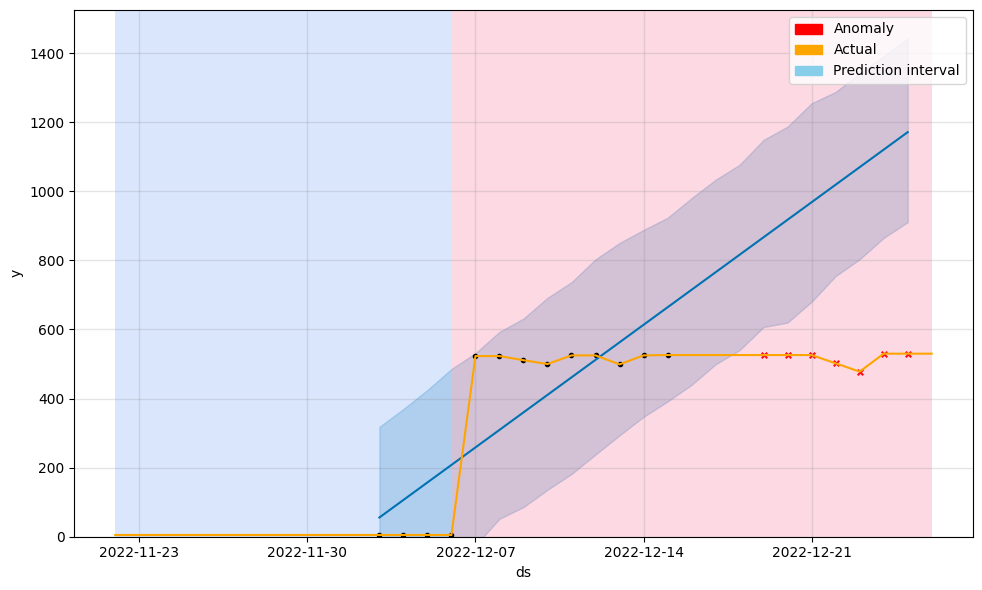

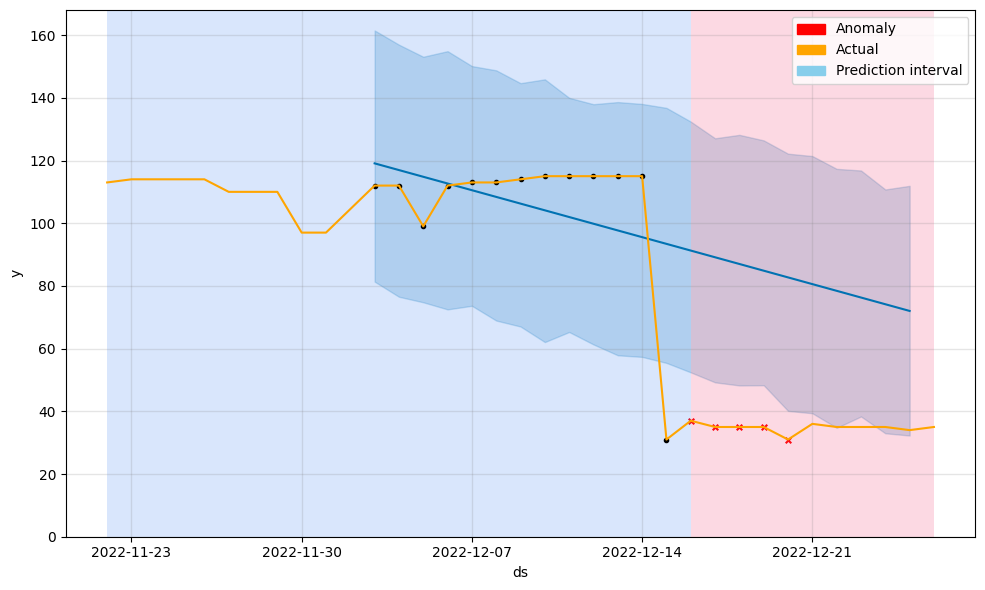

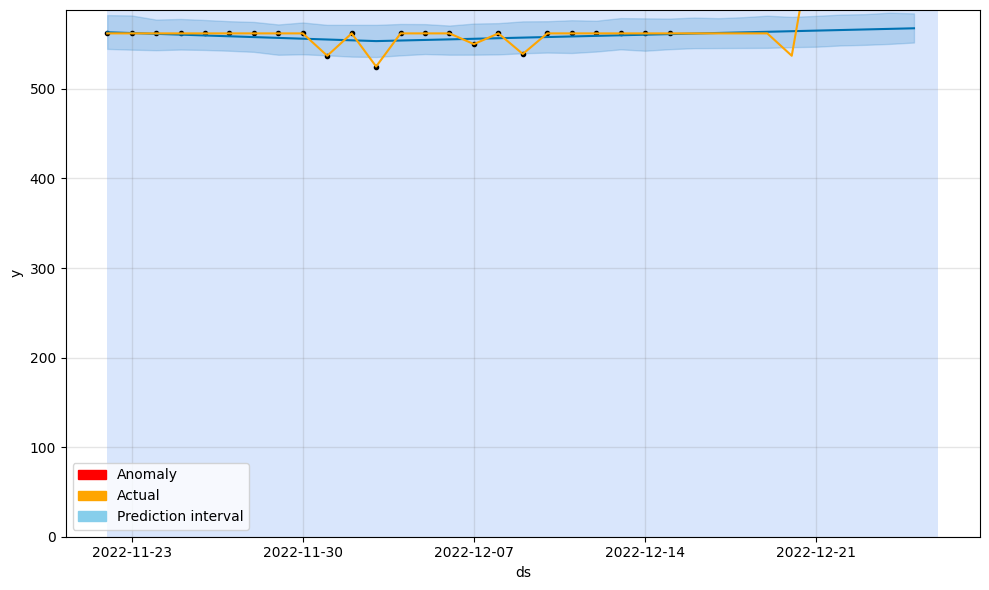

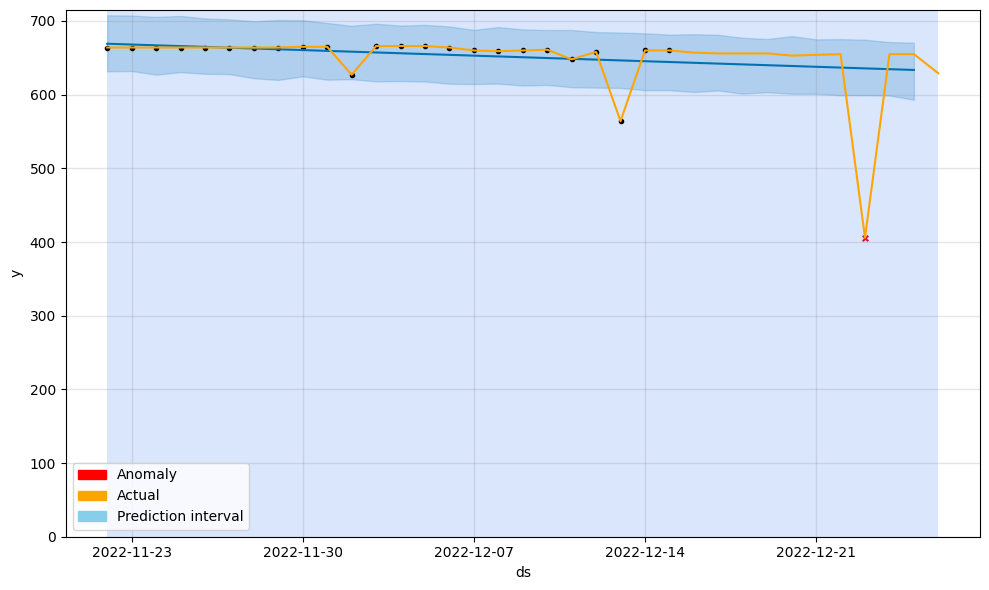

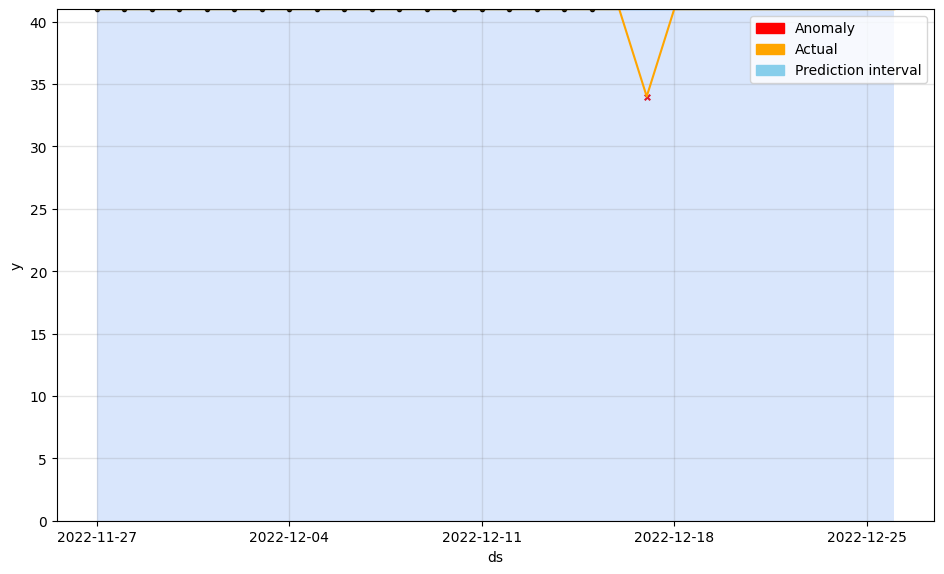

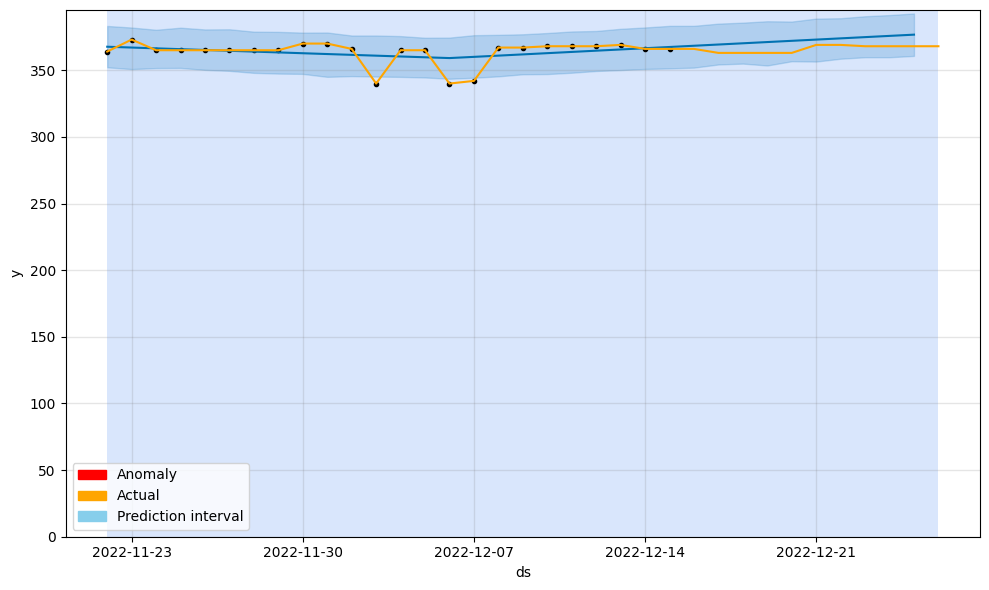

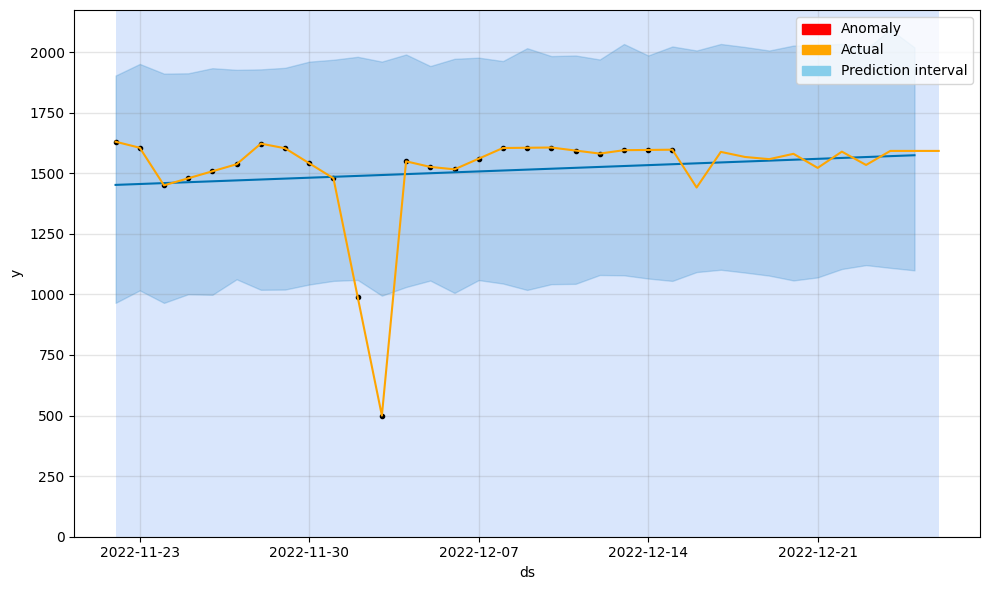

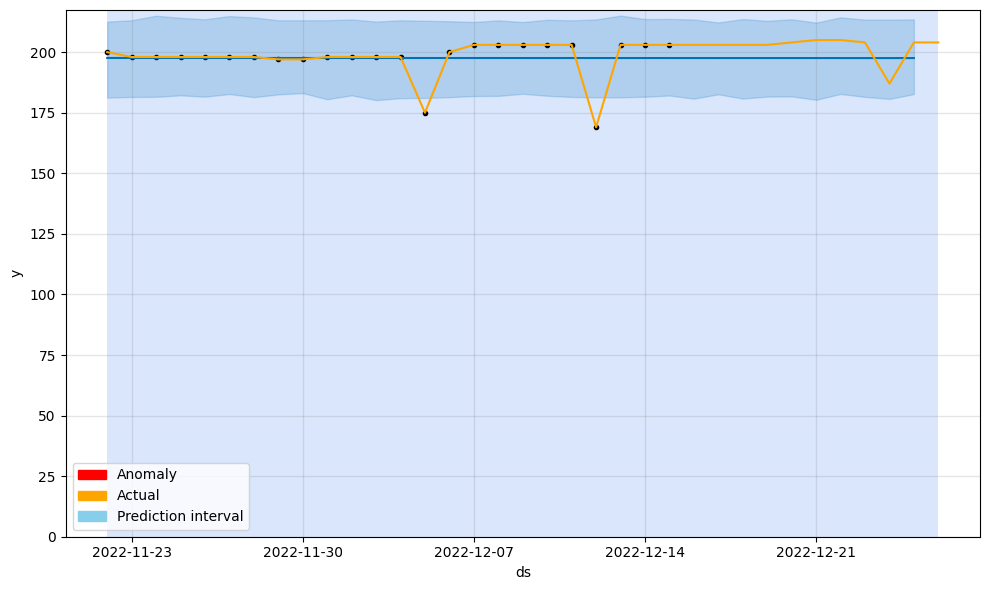

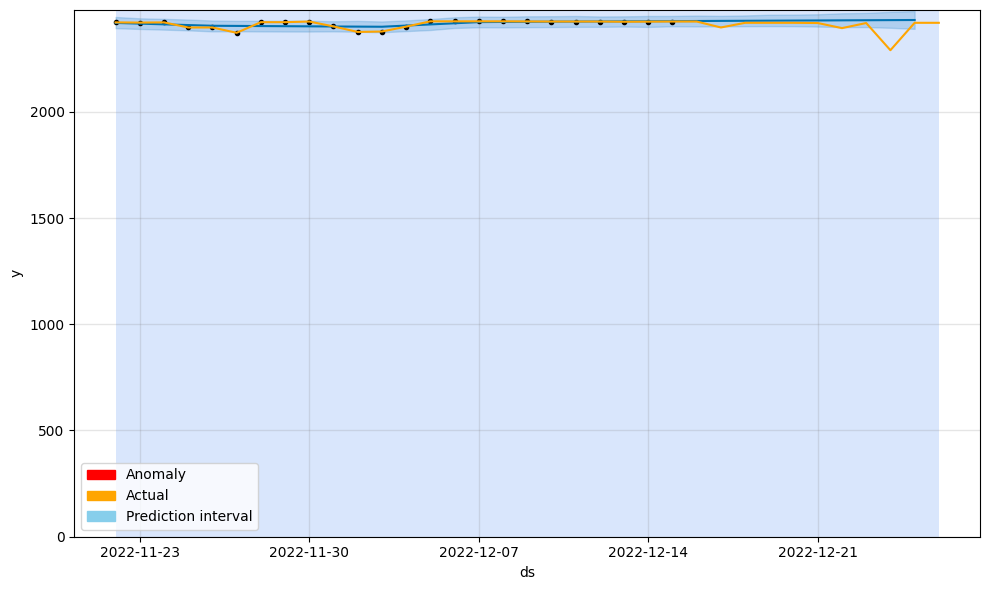

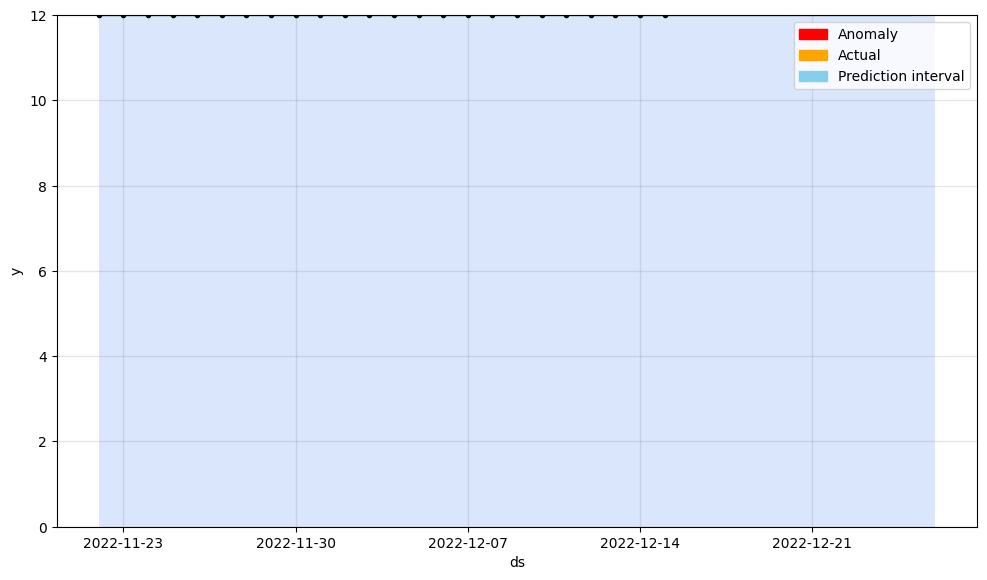

In [100]:

for ad in ads_sorted[:10]:
    prophet_plot(ad, post_to_slack=False)